In [1]:
import numpy as np
import nrrd
from os.path import *
from pylab import *
from matplotlib import patches
from JSONread import *
import xlrd
import json

DATA_FOLDER = "data/"
OUTPUT_FOLDER = "output/"

In [2]:
# Loading annotations
annotation, h = nrrd.read(join(DATA_FOLDER, "annotations.nrrd"))
dens, h = nrrd.read(join(DATA_FOLDER, "neu_density.nrrd"))
jsontextfile = open(join(DATA_FOLDER, "brain_regions.json"), "r")
jsoncontent = json.loads(jsontextfile.read())
search_children(jsoncontent['msg'][0])

In [3]:
region_tree_positions = {}
for kkk in region_dictionary_to_id.keys():
    num_parent = 0
    current_obj = kkk
    no_more_parent = False
    while no_more_parent==False:
        if region_dictionary_to_id_parent[current_obj]!="":
            num_parent += 1
            current_obj = region_dictionary_to_id_parent[current_obj]
        else:
            no_more_parent = True
    region_tree_positions[kkk] = num_parent/10.0

In [4]:
num_neurons = json.loads(open(join(DATA_FOLDER, "neuron_counts.json"), "r").read())

In [5]:
wb = xlrd.open_workbook(join(DATA_FOLDER, "gaba_papers.xlsx")) 
hasInfo = np.zeros(len(region_keys), dtype=np.bool)
for i_sheet in range(2):
    sheet = wb.sheet_by_index(i_sheet)
    for i_region in range(sheet.nrows-1):
        name = sheet.cell_value(i_region+1, 0).replace("È", "e")
        if name in region_keys:
            hasInfo[region_keys.index(name)] = 1
        else:
            print(name)
for i, kkk in enumerate(region_keys):
    if not hasInfo[i]:
        parent_ = region_dictionary_to_id_parent[kkk]
        while parent_ != "":
            if hasInfo[region_keys.index(parent_)]:
                hasInfo[i] = True
                break
            parent_ = region_dictionary_to_id_parent[parent_]

Prelimbic area, layer 4
Cerebellar cortex, Molecular layer
Cerebellar cortex, Granular layer
Somatosensory cortex


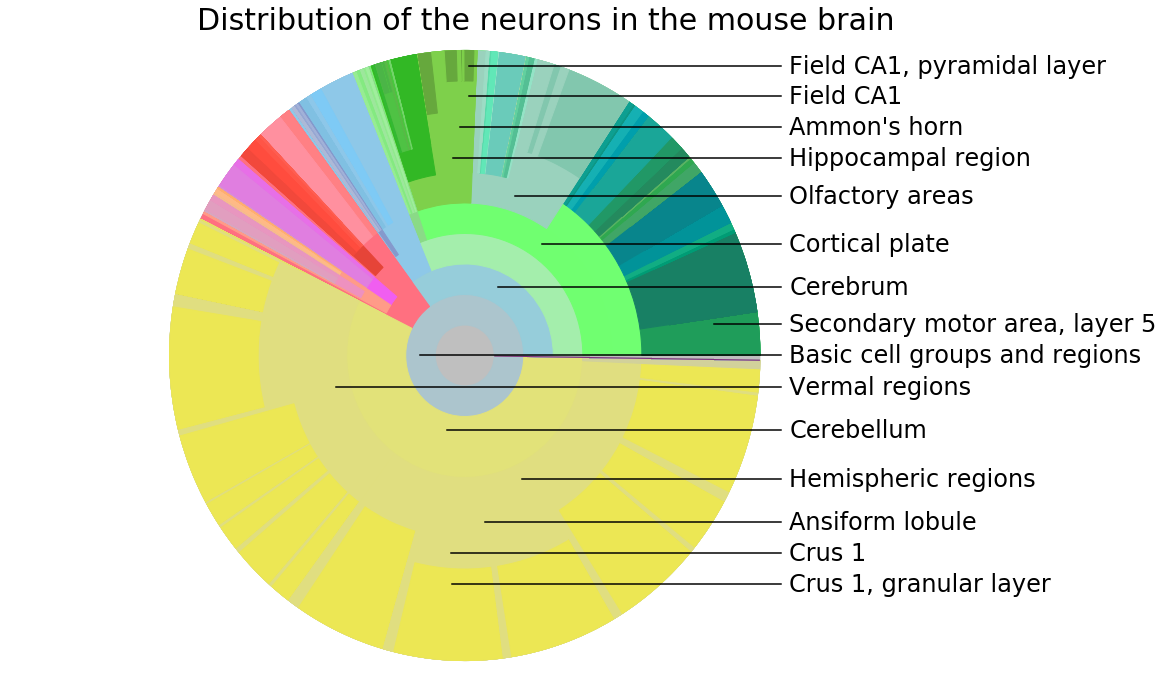

In [6]:
figScale = 1.2
cheese_text_fontsize = 24
without_cereb = False
show_known = False 

ff,ax=subplots(figsize=(14*figScale,8*figScale));
totNumCells = np.sum(dens)
cereb_allname = name2allname["Cerebellar cortex"]
cereb_num = num_neurons[cereb_allname]
if without_cereb:
    totNumCells -= cereb_num
currentCategoryPos  = {}
currentCategorySize = {}
wedgeSizes = []
wedges = {}

reg_names = []
for i, kkk in enumerate(region_keys):
    allname = name2allname[kkk]
    if without_cereb and "Cerebellar cortex" in allname:
        continue
    reg_names.append(kkk)
    isUnknown = not hasInfo[i] if show_known else False
    parent_ = region_dictionary_to_id_parent[ kkk ]
    if allname not in num_neurons:
        popRatio = 0.0
    else:
        if without_cereb and kkk in cereb_allname:
            popRatio = (num_neurons[allname]-cereb_num)/totNumCells
        else: popRatio = num_neurons[allname]/totNumCells
    if isUnknown:
        colorRegTMP = np.ones(3, dtype=np.float32)*0.7
    else:
        colorRegTMP = np.float32(np.array(region_to_color[ allname ]))/255.0
    
    if parent_=="":
        yPos = 0.0
        currentCategoryPos[  kkk ] = 0.0
        currentCategorySize[ kkk ] = 0.0
    else:
        yPos = currentCategoryPos[  parent_ ] + currentCategorySize[ parent_ ]
        currentCategoryPos[  kkk  ] = yPos
        currentCategorySize[ kkk  ] = 0.0
        currentCategorySize[ parent_ ] += popRatio
    wedges[kkk] = wedge = [(0.0, 0.0), region_tree_positions[kkk]+1.0/float(10), (yPos)*360.0, (yPos+popRatio)*360.0, colorRegTMP, isUnknown]
    ax.add_patch( patches.Wedge( wedge[0], 1.0, wedge[2], wedge[3], alpha = 1.0, color = wedge[4], width = 1.0-wedge[1]+1.0/float(10)) )
    wedgeSizes.append( np.fabs(wedge[3]-wedge[2]) )

wedgeSizesArgs = np.argsort(np.array(wedgeSizes))[::-1]
numFirstRegions = len(wedgeSizesArgs)
usedPositions = [-10.0]
for iw in range(numFirstRegions):
    kkk = np.array(reg_names)[wedgeSizesArgs[iw]]
    kkkALL = name2allname[kkk]
    wedge = wedges[kkk]
    if not wedge[5] and kkk != "root":
        textXpos = (wedge[1]-0.05)*np.sin((wedge[2]+wedge[3])*0.5*np.pi/180.0)
        if np.min(np.fabs(textXpos-np.array(usedPositions)))>0.10:
            plot( [(wedge[1]-0.05)*np.cos((wedge[2]+wedge[3])*0.5*np.pi/180.0),1.1-0.03],[(wedge[1]-0.05)*np.sin((wedge[2]+wedge[3])*0.5*np.pi/180.0),textXpos], "-", color=[0.0,0.0,0.0] )
            text( 1.1, textXpos, kkk, fontsize=cheese_text_fontsize, alpha=1.0, color=[0.0,0.0,0.0], horizontalalignment="left", verticalalignment="center" )
            usedPositions.append( textXpos )
xlim([-1.05-0.50, 2.10])
ylim([-1.05, 1.05])
ax.axis('off')
if show_known:
    title("Literature coverage for GAD67 densities in the mouse brain", fontsize=30)
else: 
    title("Distribution of the neurons in the mouse brain", fontsize=30)
tight_layout()
    
filename = "literature_coverage" if show_known else "neu_counts"
if without_cereb:
    filename+="_without_cereb"

savefig(join(OUTPUT_FOLDER, filename), dpi=400)